In [2]:
# pyABC example

import pyabc
import json
from pyabc import (ABCSMC,
                   RV, Distribution)
import numpy as np
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

from ssd import fixedSSD
from stoptaskstudy import StopTaskStudy
%matplotlib inline


In [3]:
def stopsignal_model(parameters):
    paramfile = 'params.json'
    with open(paramfile) as f:
            params = json.load(f)
    # install the parameters from the simulation
    params['mu']['go'] = parameters['mu_go']
    params['mu']['stop'] = parameters['mu_go'] + parameters['mu_stop_delta']
    params['mu_delta_incorrect']  = parameters['mu_delta_incorrect']
    # TBD
    #    if args.p_guess_file is not None:
    #        p_guess = pd.read_csv(args.p_guess_file, index_col=0)
    #        assert 'SSD' in p_guess.columns and 'p_guess' in p_guess.columns

    #    if args.random_seed is not None:
    #        np.random.seed(args.random_seed)

    min_ssd, max_ssd, ssd_step = 0, 550, 50
    ssd = fixedSSD(np.arange(min_ssd, max_ssd + ssd_step, ssd_step))

    study = StopTaskStudy(ssd, None, params=params)

    trialdata = study.run()

    # summarize data - go trials are labeled with SSD of -inf so that
    # they get included in the summary
    stop_data = trialdata.groupby('SSD').mean().query('SSD >= 0').resp.values
    return {'data': stop_data}

parameter_prior = Distribution(mu_go=RV("uniform", 0, 1),
                               mu_stop_delta=RV("uniform", 0, 1),
                              mu_delta_incorrect=RV("uniform", 0, 1))
parameter_prior.get_parameter_names()


['mu_delta_incorrect', 'mu_go', 'mu_stop_delta']

In [4]:

def distance(simulation, data):
    return(np.sqrt(np.sum((simulation['data'] - data['data'])**2)))

abc = ABCSMC(stopsignal_model, parameter_prior, distance)


INFO:Sampler:Parallelizing the sampling on 4 cores.


In [5]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
observed_presp = pd.read_csv('presp_by_ssd_inperson.txt',  delimiter=r"\s+", index_col=0)
abc.new(db_path, {"data": observed_presp.presp.values})

INFO:History:Start <ABCSMC(id=1, start_time=2020-12-05 08:01:47.870737, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=.1, max_nr_populations=100)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 1.0899204275811851
INFO:ABC:t: 0, eps: 1.0899204275811851.
INFO:ABC:Acceptance rate: 100 / 259 = 3.8610e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.7705978261019717.
INFO:ABC:Acceptance rate: 100 / 214 = 4.6729e-01, ESS=7.8924e+01.
INFO:ABC:t: 2, eps: 0.5582568667030958.
INFO:ABC:Acceptance rate: 100 / 198 = 5.0505e-01, ESS=8.6715e+01.
INFO:ABC:t: 3, eps: 0.48383163174900634.
INFO:ABC:Acceptance rate: 100 / 202 = 4.9505e-01, ESS=8.6254e+01.
INFO:ABC:t: 4, eps: 0.4404035627384456.
INFO:ABC:Acceptance rate: 100 / 260 = 3.8462e-01, ESS=4.3694e+01.
INFO:ABC:t: 5, eps: 0.38211356845769223.
INFO:ABC:Acceptance rate: 100 / 261 = 3.8314e-01, ESS=7.8933e+01.
INFO:ABC:t: 6, eps: 0.3385252701925943.
INFO:ABC:Acceptance rate: 100 / 250 = 4.0000e-01, ESS=8.2775e+01.
INFO:ABC:t: 7, eps: 0.30416179109853864.


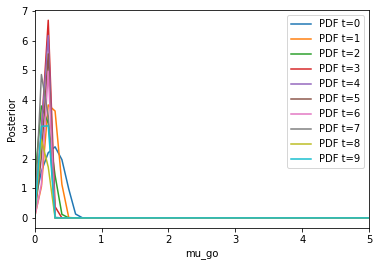

In [50]:
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=5,
        x="mu_go", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(observed_presp.presp.values, color="k", linestyle="dashed");
ax.legend();


ValueError: x and y must be the same size

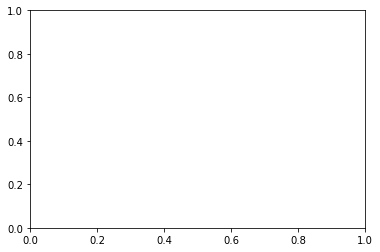

In [51]:
df, w = history.get_distribution(m=0, t=history.max_t)
plt.scatter(df, w)

In [55]:
df.iloc[np.argmin(w),:]

name
mu_delta_incorrect    0.774443
mu_go                 0.129610
mu_stop_delta         0.226288
Name: 1419, dtype: float64

In [56]:
presp = stopsignal_model({'mu_go':0.774443, 'mu_stop_delta': 0.129610, 'mu_delta_incorrect': 0.226288})

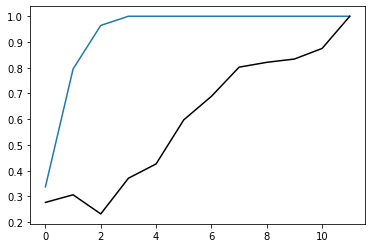

In [60]:
plt.plot(presp['data'])
plt.plot(observed_presp.presp.values, 'k')